In [2]:
from keras.layers import *
from keras.models import *
from keras import Input
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'

In [3]:
def identity_block(x, f_kernel_size, filters, dilation, pad):
    filters_1, filters_2, filters_3 = filters
    x_shortcut = x
    x = Conv2D(filters=filters_1, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(x)
    x = Conv2D(filters=filters_2, kernel_size=f_kernel_size, strides=(1, 1), activation='relu', padding='same',
                   dilation_rate=dilation, kernel_initializer=glorot_uniform(seed=0))(x)
    # stage 3
    x = Conv2D(filters=filters_3, kernel_size=(1, 1), strides=(1, 1), padding='same',
               kernel_initializer=glorot_uniform(seed=0))(x)
    # stage 4
    x = Add()([x, x_shortcut])
    x = Activation(activation='relu')(x)
    
    return x

In [4]:
def conv_block(x, f_kernel_size, filters, strides, dilation, pad):
    filters_1, filters_2, filters_3 = filters
    x_shortcut = x
    # stage 1
    x = Conv2D(filters=filters_1, kernel_size=(1, 1), strides=strides, padding='same', activation='relu',
                   kernel_initializer=glorot_uniform(seed=0))(x)
    # stage 2

    x = Conv2D(filters=filters_2, kernel_size=f_kernel_size, strides=(1, 1), activation='relu', padding='same',
               dilation_rate=dilation, kernel_initializer=glorot_uniform(seed=0))(x)
    # stage 3
    x = Conv2D(filters=filters_3, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(x)
    # stage 4
    x_shortcut = Conv2D(filters=filters_3, kernel_size=(1, 1), strides=strides, padding='same',
                            kernel_initializer=glorot_uniform(seed=0))(x_shortcut)
    # stage 5
    x = Add()([x, x_shortcut])
    x = Activation(activation='relu')(x)
    return x

In [5]:
def _resnet50(inputs):
    # 特征图大小下降一半
    x = Conv2D(filters=64, kernel_size=7, strides=2, padding='SAME', activation='relu', use_bias=False)(inputs)
    x = MaxPool2D(pool_size=3, strides=2, padding='SAME')(x)
    
    x = conv_block(x, f_kernel_size=(3, 3), filters=[64, 64, 256], strides=1, pad=(1, 1), dilation=1)
    x = identity_block(x, f_kernel_size=(3,3), filters=[64,64,256], pad=(1,1), dilation=1)
    x = identity_block(x, f_kernel_size=(3,3), filters=[64,64,256], pad=(1,1), dilation=1)
    
    x = conv_block(x, f_kernel_size=(3, 3), filters=[128, 128, 512], strides=2, pad=(1, 1), dilation=1)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[128, 128, 512], pad=(1, 1), dilation=1)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[128, 128, 512], pad=(1, 1), dilation=1)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[128, 128, 512], pad=(1, 1), dilation=1)
 
    x = conv_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], strides=1, pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    
    x = conv_block(x, f_kernel_size=(3, 3), filters=[512, 512, 2048], strides=1, pad=(4, 4), dilation=4)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 2048], pad=(4, 4), dilation=4)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 2048], pad=(4, 4), dilation=4)
 
    return x

In [6]:
def ResNet50(input_shape):
    inputs = Input(input_shape)
    outputs = _resnet50(inputs)
    
    model = Model(inputs, outputs)
    
    return model

In [7]:
# model = ResNet50((512, 512, 3))
# model.summary()
# plot_model(model, to_file='ResNet50.png',show_shapes=True)

In [8]:
def build_pspnet(input_shape, num_class):
    inputs = Input(input_shape)
#     [inputs, features] = get_feature_map()
    features = _resnet50(inputs)
    # 金字塔池化
    x_c1 = AveragePooling2D(pool_size=60, strides=60, name='ave_c1')(features)
    x_c1 = Conv2D(filters=512, kernel_size=1, strides=1, padding='SAME', activation='relu',  name='conv_c1')(x_c1)
    # x_c1 = Dropout(0.2)(x_c1)
    x_c1 = UpSampling2D(size=(60, 60), name='up_c1')(x_c1)

    x_c2 = AveragePooling2D(pool_size=30, strides=30, name='ave_c2')(features)
    x_c2 = Conv2D(filters=512, kernel_size=1, strides=1, padding='SAME', activation='relu', name='conv_c2')(x_c2)
    # x_c2 = Dropout(0.2)(x_c2)
    x_c2 = UpSampling2D(size=(30, 30), name='up_c2')(x_c2)

    x_c3 = AveragePooling2D(pool_size=20, strides=20, name='ave_c3')(features)
    x_c3 = Conv2D(filters=512, kernel_size=1, strides=1, padding='SAME', activation='relu', name='conv_c3')(x_c3)
    # x_c3 = Dropout(0.2)(x_c3)
    x_c3 = UpSampling2D(size=(20, 20), name='up_c3')(x_c3)

    x_c4 = AveragePooling2D(pool_size=10, strides=10, name='ave_c4')(features)
    x_c4 = Conv2D(filters=512, kernel_size=1, strides=1, padding='SAME', activation='relu', name='conv_c4')(x_c4)
    # x_c4 = Dropout(0.2)(x_c4)
    x_c4 = UpSampling2D(size=(10, 10), name='up_c4')(x_c4)

    x_c5 = Conv2D(filters=512, kernel_size=1, strides=1, name='conv_c5', activation='relu', padding='SAME')(features)
    # x_c5 = Dropout(0.2)(x_c5)

    x = Concatenate(axis=-1, name='concat')([x_c1, x_c2, x_c3, x_c4, x_c5])
    x = Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME', activation='relu', name='sum_conv_1_11')(x)


    x = UpSampling2D(size=(4, 4))(x)

    outputs = Conv2D(filters=num_class, kernel_size=1, strides=1, padding='SAME', name='sum_conv_2',
                     activation='softmax')(x)
    # TODO 记得删除
#     outputs = Reshape((240 * 240, -1))(outputs)
#     outputs = Softmax()(outputs)
    model = Model(inputs, outputs)
    # model.summary()
    return model

In [9]:
model = build_pspnet((480, 480, 3), 12)
model.summary()
# plot_model(model, to_file='PSPNet.png',show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 120, 120, 64) 4160        max_pooling2d_1[0][0]            
____________________

In [10]:
from generate_data2 import *
from Unet import *
from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [11]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=["accuracy"])
tb_cb = TensorBoard(log_dir='CamVid/pspnet')
model_checkpoint = ModelCheckpoint('CamVid_model_v1.hdf5', monitor='val_loss',verbose=1,save_best_only=True)
rl = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3,
    verbose=1
)
es = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=7, 
    verbose=1
)
csv_logger = CSVLogger('CamVid/pspnet/training.csv', separator=',',)

In [12]:
train_data = trainGenerator(batch_size=1)
valid_data = validLoad(batch_size=1)
test_data = testGenerator()

In [13]:
# history = model.fit_generator(train_data,
#                               steps_per_epoch=200,
#                               epochs=50,
#                               validation_steps=10,
#                               validation_data=valid_data,
#                               callbacks=[model_checkpoint,tb_cb,rl,es,csv_logger])

In [16]:
# history = model.fit_generator(train_data,
#                               steps_per_epoch=200,
#                               epochs=60,
#                               initial_epoch=50,
#                               validation_steps=10,
#                               validation_data=valid_data,
#                               callbacks=[model_checkpoint,tb_cb,rl,es,csv_logger])

In [17]:
# model.save_weights('CamVid/pspnet'+'/last1.h5')

In [18]:
model.load_weights('CamVid/pspnet'+'/last1.h5')

In [19]:
model.get_config()

{'name': 'model_1',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 480, 480, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv2d_1',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_1', 0, 0, 

In [20]:
path = '/home/possibleit/文档/dataset/CamVid/test/Seq05VD_f05100.png'
path2 = '/home/possibleit/文档/dataset/CamVid/testannot/Seq05VD_f05100.png'
import numpy as np
from keras.preprocessing import image

In [21]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

In [24]:
one = [128, 128, 128]
two = [128, 0, 0]
three = [192, 192, 128]
four = [255, 69, 0]
five = [128, 64, 128]
six = [60, 40, 222]
seven = [128, 128, 0]
eight = [192, 128, 128]
nine = [64, 64, 128]
ten = [64, 0, 128]
eleven = [64, 64, 0]
twelve = [0, 128, 192]
COLOR_DICT = np.array([one, two,three,four,five,six,seven,eight,nine,ten,eleven,twelve])

In [25]:
COLOR_DICT[0]

array([128, 128, 128])

In [50]:
(x, y) = trainGenerator(batch_size=1).__next__()
img = model.predict(x)
img = np.squeeze(img)
img.shape

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.


(240, 240, 12)

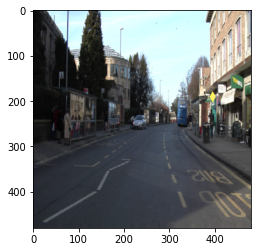

(240, 240, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


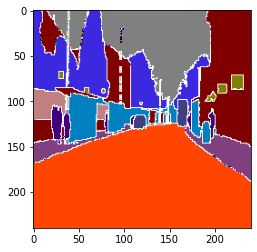

array([ 60,  40, 222])

In [51]:
x = np.squeeze(x)
y = np.squeeze(y)
plt.imshow(x)
plt.show()
res = np.empty([240,240,3], dtype = int)
print(res.shape)
for i in range(240):
    for j in range(240):
        for k in range(12):
            if y[i][j][k] == 1:
                res[i][j] = COLOR_DICT[k]
                break
plt.imshow(res)
plt.show()
res[0][0]

(240, 240, 3)


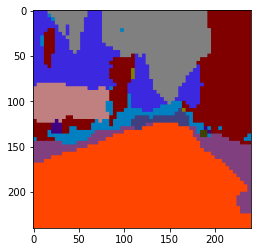

In [52]:
iii = np.empty([240,240,3], dtype = int)
print(iii.shape)
for i in range(240):
    for j in range(240):
        iii[i][j] = COLOR_DICT[np.argmax(img[i][j])]
plt.imshow(iii)

In [53]:
x2 = testGenerator().__next__()
print(x2.shape)
img2 = model.predict(x2)
img2 = np.squeeze(img2)
img2.shape

(1, 480, 480, 3)


(240, 240, 12)

(240, 240, 3)


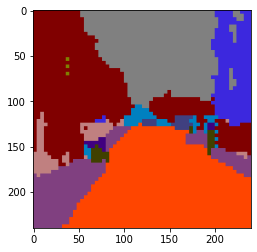

In [54]:
iii = np.empty([240,240,3], dtype = int)
print(iii.shape)
for i in range(240):
    for j in range(240):
        iii[i][j] = COLOR_DICT[np.argmax(img2[i][j])]
plt.imshow(iii)

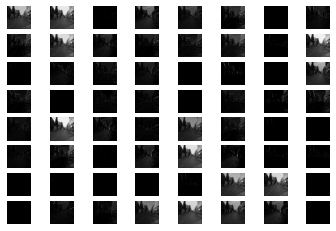

In [55]:
from keras import backend as K
layer_1 = K.function([model.layers[0].input],[model.layers[1].output])
x = np.expand_dims(x, axis=0)
f1 = layer_1([x])[0]

for _ in range(64):
    show_img = f1[:, :, :, _]
    show_img.shape = [240, 240]
    plt.subplot(8, 8, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

In [56]:
# p_model = Model(inputs=model.input,outputs=model.get_layer('add_16').output)


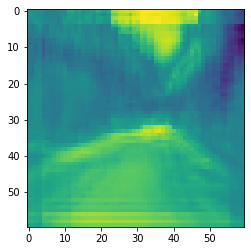

In [58]:
layer_1 = K.function([model.layers[0].input],[model.get_layer('add_16').output])
f1 = layer_1([x])[0]
show_img = f1[:, :, :, _]
show_img.shape = [60, 60]
plt.imshow(show_img)
plt.show()